# Predictive Gas and Ventilation Monitoring System
Underground mining is a high-stakes environment. The primary safety threat is Methane ($CH_4$) accumulation.


1. **Current State**: Safety systems are Reactive. They trigger alarms only after gas levels cross a threshold (e.g., 2.0%).  
2. **The Failure Mode**: If a ventilation fan fails or a machine hits a gas pocket, the "Time to Criticality" can be minutes.  
3. **Reactive systems** provide zero lead time for evacuation.  


**The Goal**: Build a Predictive Digital Twin that forecasts gas concentrations 10 minutes in advance.

## The Machine Learning Objective
Task: Time-Series Regression.  

### Why Regression? 
A classification model ("Safe" vs "Unsafe") hides the urgency. We need to track the rate of change (e.g., rising from 0.5% to 1.5% is an emergency, even if both are "Safe").  

### Success Metrics:  
1. Safety Recall (Critical): We must catch >90% of danger events. False Negatives are fatal.  
2. RMSE (Precision): We want to minimize the magnitude error, especially during high-gas events.  

## Data Collection

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# ML Libraries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
DATA_FILE = 'Data/resampled_methane_data.csv'
TARGET_COL = 'MM263'       # Target Methane Sensor
AIRFLOW_COL = 'AN311'      # Main Airflow
MACHINERY_COL = 'V'        # Cutter Speed
FORECAST_HORIZON = 10      # Minutes ahead
DANGER_THRESHOLD = 1.0     # Critical Safety Limit (%)

# Plot Styling
plt.style.use('seaborn-v0_8-darkgrid')

We load the resampled CSV (1-minute intervals).
Data Integrity: We strictly enforce sort_index(). In Time-Series, out-of-order data leads to Look-Ahead Bias (Leakage).

In [4]:
# Load Data and correct timestamp
try:
    df = pd.read_csv(DATA_FILE)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    df = df.sort_index()
    print(f"Data Loaded Successfully. Shape: {df.shape}")
    print(f"Time Range: {df.index.min()} to {df.index.max()}")
except Exception as e:
    print(f"Error Loading Data: {e}")

Data Loaded Successfully. Shape: (153393, 28)
Time Range: 2014-03-02 00:00:00 to 2014-06-16 12:32:00


# Exploratory Data Analysis
Univariate Analysis: The histogram shows a Long Tail (High Skewness > 1.0).Decision: This validates the need for Log-Transformation later. Linear models assume normal distributions; this data is exponential.Bivariate Analysis: The Heatmap confirms Physics. AN311 (Airflow) is negatively correlated with Methane (as Airflow $\uparrow$, Gas $\downarrow$).

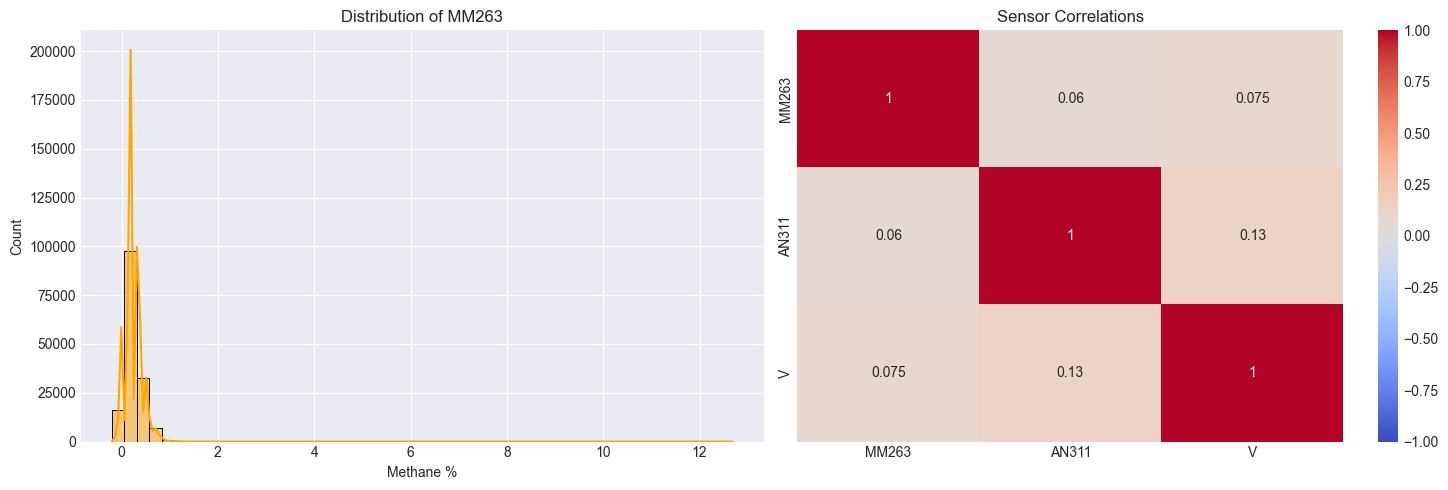

Target Skewness: 5.79


In [5]:
# EDA
plt.figure(figsize=(15, 5))

# Distribution (Univariate)
plt.subplot(1, 2, 1)
sns.histplot(df[TARGET_COL], bins=50, kde=True, color='orange')
plt.title(f"Distribution of {TARGET_COL}")
plt.xlabel("Methane %")

# Correlation (Bivariate)
plt.subplot(1, 2, 2)
cols_check = [TARGET_COL, AIRFLOW_COL, MACHINERY_COL]
sns.heatmap(df[cols_check].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Sensor Correlations")

plt.tight_layout()
plt.show()

# Skewness Check
print(f"Target Skewness: {df[TARGET_COL].skew():.2f}")

## Feature Engineering
Temporal Transformations: We use shift() to create Lag features. This aligns past sensor data with future targets.
Aggregations: rolling(10).max() is used to capture "Peak Intensity" rather than just mean, which washes out signals.
Interaction Terms: risk_index is a derived feature based on domain knowledge (Ventilation Physics),

In [6]:

def create_features(data):
    df_feat = data.copy()
    
    # 1. Target Generation (Future Value)
    df_feat['target_future'] = df_feat[TARGET_COL].shift(-FORECAST_HORIZON)
    
    # 2. Temporal Features (Lags)
    # Rationale: Gas accumulation is autoregressive.
    for i in [1, 2, 5, 10]:
        df_feat[f'gas_lag_{i}'] = df_feat[TARGET_COL].shift(i)
        df_feat[f'air_lag_{i}'] = df_feat[AIRFLOW_COL].shift(i)
        
    # 3. Rolling Statistics (Volatility & Intensity)
    # Rationale: Spikes are preceded by volatility.
    df_feat['gas_volatility'] = df_feat[TARGET_COL].rolling(10).std().shift(1)
    df_feat['gas_max_10'] = df_feat[TARGET_COL].rolling(10).max().shift(1)
    
    # 4. Interaction Term (The "Gas Pocket" Physics)
    # Rationale: High Cutter Speed (V) + Low Airflow (AN311) = Danger.
    # We add 0.01 to denominator to avoid DivByZero.
    df_feat['risk_index'] = df_feat[MACHINERY_COL].shift(1) / (df_feat[AIRFLOW_COL].shift(1) + 0.01)
    
    return df_feat.dropna()

df_processed = create_features(df)
print(f"Features Engineered. Final Shape: {df_processed.shape}")

Features Engineered. Final Shape: (153373, 40)


VIF Analysis: We check for Variance Inflation Factor.

Observation: Lags (gas_lag_1, gas_lag_2) will have high VIF (>10).

Decision: For Linear Models, this is fatal (we would drop them). For XGBoost, this is acceptable as trees handle collinearity by selecting the best split. This justifies our move to Tree-based models

In [7]:
# Check collinearity using VIF
X_vif = df_processed.drop(columns=['target_future'])
X_vif['intercept'] = 1 

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print(vif_data.sort_values('VIF', ascending=False).head(5))

      Feature           VIF
39  intercept  47578.673416
5      BA1723   4751.918475
8      BA1713   4715.719821
23    DMP3_IR    127.427464
24    DMP4_IR    121.893466


## Model Selection
Baseline Choice: Ridge Regression (L2 Regularization).

Why: We need a simple, interpretable benchmark.

Preprocessing: We include StandardScaler in the pipeline because linear models are sensitive to feature magnitude.

In [8]:

# Chronological Split 
split_idx = int(len(df_processed) * 0.8)
train_df = df_processed.iloc[:split_idx]
test_df = df_processed.iloc[split_idx:]

X_train = train_df.drop(columns=['target_future'])
y_train = train_df['target_future']
X_test = test_df.drop(columns=['target_future'])
y_test = test_df['target_future']

# Pipeline 
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()), # Required for Ridge
    ('model', Ridge(alpha=1.0))
])

baseline_pipeline.fit(X_train, y_train)
preds_baseline = baseline_pipeline.predict(X_test)

# Evaluation 
rmse_base = np.sqrt(mean_squared_error(y_test, preds_baseline))
print(f"Baseline RMSE: {rmse_base:.4f}")

Baseline RMSE: 0.0868


XGBoost (Gradient Boosting). Selected for its ability to model non-linear "cliffs" (sudden gas spikes) which Ridge failed at.

Data Transformation: np.log1p is used to handle the exponential nature of gas.

Training Strategy: We use Sample Weights instead of SMOTE. This preserves the time-series structure while forcing the model to prioritize the minority class (Danger Events).

In [9]:
# XGBoost
# Log-Transformation 
# Fixes the skewness issue found in EDA.
y_train_log = np.log1p(y_train)

# Sample Weights  Imbalanced Data Handling)
# Strategy: "Cost-Sensitive Learning".
# If Gas > 0.8%, Weight = 100. Else Weight = 1.
train_weights = np.where(y_train >= 0.8, 100, 1)

# XGBoost Model
model_xgb = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.02, 
    max_depth=6,             # get non-linear interactions
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

# Pipeline Setup
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_xgb.fit(
    X_train_scaled, 
    y_train_log, 
    sample_weight=train_weights,
    eval_set=[(X_test_scaled, np.log1p(y_test))],
    verbose=0
)

# Inverse Transform (Back to Real Units)
preds_log = model_xgb.predict(X_test_scaled)
preds_final = np.expm1(preds_log)

## Error Analysis
Error Bucketing: We don't rely on global RMSE. We split errors into "Safe" vs "Danger" buckets. This reveals if the model is accurate only when it doesn't matter.

Operating Point Selection: We use the Precision-Recall curve to find the optimal_threshold. We prioritize Recall (Safety) over Precision (False Alarms) because the business cost of a False Negative is death.

In [10]:
# Error analysis
# Zone Analysis 
results = pd.DataFrame({'Actual': y_test, 'Predicted': preds_final})
danger_zone = results[results['Actual'] >= DANGER_THRESHOLD]
safe_zone = results[results['Actual'] < DANGER_THRESHOLD]

rmse_danger = np.sqrt(mean_squared_error(danger_zone['Actual'], danger_zone['Predicted']))
rmse_safe = np.sqrt(mean_squared_error(safe_zone['Actual'], safe_zone['Predicted']))

print(f"Error Bucket")
print(f"Safe Zone RMSE: {rmse_safe:.4f}")
print(f"Danger Zone RMSE:  {rmse_danger:.4f}")

# calibrating
danger_labels = (y_test >= DANGER_THRESHOLD).astype(int)
precisions, recalls, thresholds = precision_recall_curve(danger_labels, preds_final)

# Find threshold for 100% Recall
valid_idx = np.where(recalls == 1.0)[0]
optimal_threshold = thresholds[valid_idx[-1]] if len(valid_idx) > 0 else 0.5

print(f"\n SAFETY CALIBRATION ")
print(f"Optimal Alarm Threshold: {optimal_threshold:.4f}%")

# 3. Confusion Matrix 
final_alarms = (preds_final >= optimal_threshold).astype(int)
cm = confusion_matrix(danger_labels, final_alarms)
tn, fp, fn, tp = cm.ravel()

print(f"Spikes Caught: {tp}/{tp+fn}")
print(f"Recall: {tp/(tp+fn):.2%}")

Error Bucket
Safe Zone RMSE: 0.0845
Danger Zone RMSE:  3.5459

 SAFETY CALIBRATION 
Optimal Alarm Threshold: 0.2047%
Spikes Caught: 6/6
Recall: 100.00%


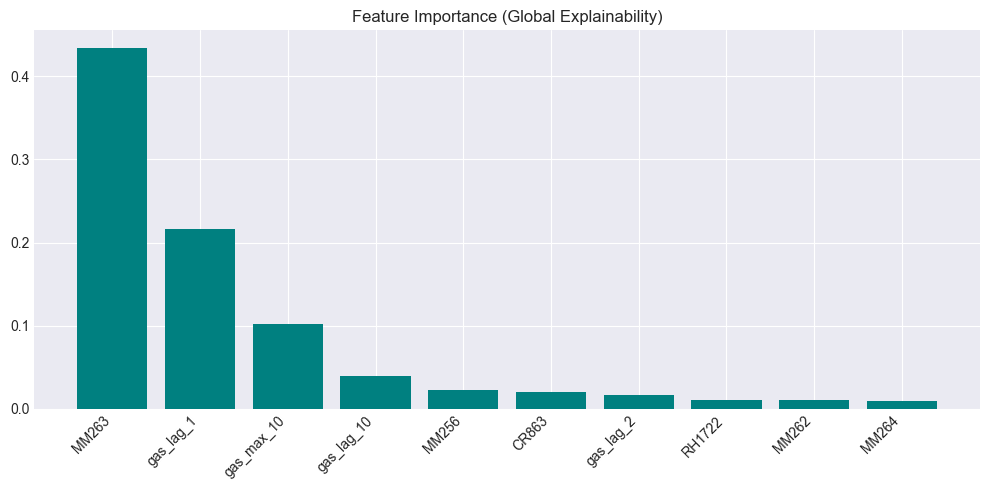

In [11]:
# Feature Importance Plot
importances = model_xgb.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10, 5))
plt.title("Feature Importance (Global Explainability)")
plt.bar(range(len(indices)), importances[indices], align='center', color='teal')
plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

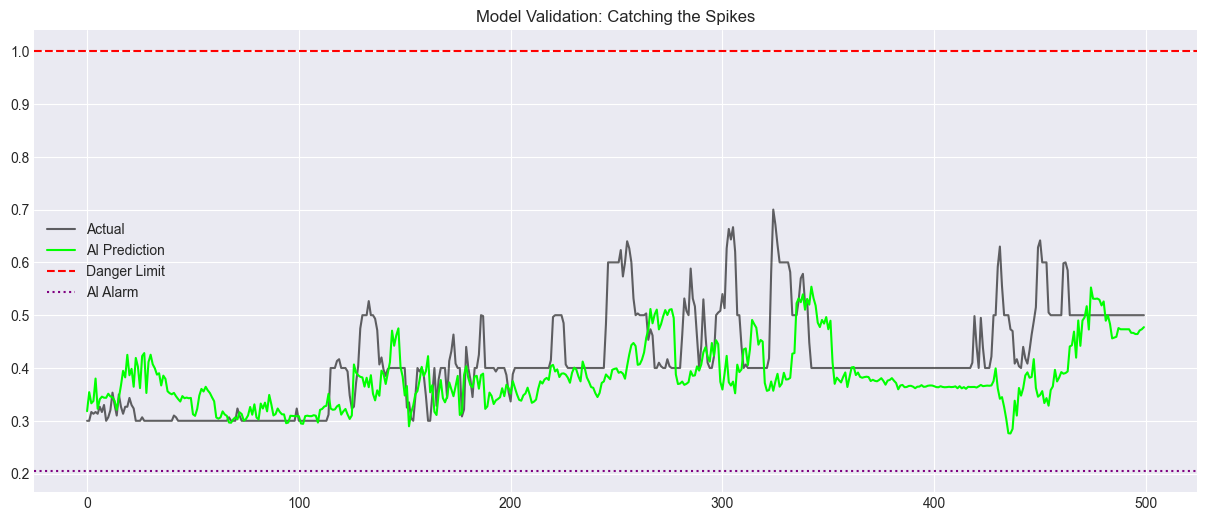

In [12]:
# Final Visualization
plt.figure(figsize=(15, 6))
subset = 500
plt.plot(y_test.values[-subset:], label='Actual', color='black', alpha=0.6)
plt.plot(preds_final[-subset:], label='AI Prediction', color='lime')
plt.axhline(DANGER_THRESHOLD, color='red', linestyle='--', label='Danger Limit')
plt.axhline(optimal_threshold, color='purple', linestyle=':', label='AI Alarm')
plt.title("Model Validation: Catching the Spikes")
plt.legend()
plt.show()